In [1]:
import copy
import glob
import importlib
import os

In [2]:
import cv2
import ee
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import tqdm

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nitelite_mapmaker

In [5]:
importlib.reload(nitelite_mapmaker)

<module 'nitelite_mapmaker' from '/Users/Shared/repos/NITELite-mapmaker/nitelite_mapmaker/__init__.py'>

# Settings

In [6]:
flight_name = '220513-FH135'
data_dir = '/Users/Shared/data'
google_drive_dir = '/Users/zhafensaavedra/Google Drive'

In [7]:
image_dir = os.path.join(data_dir, 'nitelite/images', flight_name, '23085686' )
metadata_dir = os.path.join(google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Old NITELite Flights', flight_name, 'data')
img_log_fp = os.path.join(metadata_dir, 'image.log')
imu_log_fp = os.path.join(metadata_dir, 'OBC/PresIMULog.csv')
gps_log_fp = os.path.join(metadata_dir, 'OBC/GPSLog.csv')

In [8]:
percent_for_landed = 95.
percent_for_cruising = 10.
mult_of_std_for_steady = 2.
column_for_steady = 'imuGyroX'
rolling_window_in_min = 1.

# offset between image and UTC based on timezone
img_to_metadata_tz_offset_in_hr = 5

In [9]:
ground_alt = 220. # In m above sea level
cart_crs = 'EPSG:3532' # E Indiana
cart_crs = 'EPSG:3857' # Google maps
ang_crs = 'EPSG:4326'

In [10]:
img_angular_width = 23.4 # In degrees
img_angular_height = 14.8 # In degrees
img_angular_error = 1.1
img_radius_cap = 2.
camera_num = 0

In [11]:
mosaic_res = 1000. # In meters

In [12]:
decent_test_seeds = [111, 1631489, ]
rng = np.random.default_rng(decent_test_seeds[0])

In [13]:
palette = sns.color_palette('deep')

## Setup

In [14]:
mm = nitelite_mapmaker.mapmaker.Mapmaker(
    image_dir=image_dir,
    img_log_fp=img_log_fp,
    imu_log_fp=imu_log_fp,
    gps_log_fp=gps_log_fp,
)

In [15]:
mm.prep()

# Inspect Flight

## Parse into flight phases

We can use the pressure to divide the flight up into approximate phases.

In [16]:
imu_log_df = mm.flight.imu_log_df

In [17]:
# Convert to datetime, toss out IMU recordings not associated with the 5-13 flight.
imu_log_df.drop(
    imu_log_df.index[imu_log_df['CurrTimestamp'] < pd.to_datetime('2022-5-13 20')],
    inplace=True,
)

In [18]:
# We'll divide up into phases based on pressure relative to max or min pressure.
p_max = imu_log_df['pressure'].max()
p_min = imu_log_df['pressure'].min()
p_diff = p_max - p_min
p_landed = p_min + percent_for_landed / 100. * p_diff
p_cruising = p_min + percent_for_cruising / 100. * p_diff

In [19]:
# Identify the transition phases
phases = ['pre-flight', 'ascent', 'cruise', 'descent', 'post-flight'] # For reference
phase_values = []
transition_indices = []
j = 0
for i, p in enumerate(imu_log_df['pressure']):
    
    # Pre-flight to ascent
    if j == 0:
        if p < p_landed:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 1:
        if p < p_cruising:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 2:
        if p > p_cruising:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    elif j == 3:
        if p > p_landed:
            transition_indices.append(imu_log_df.index[i])
            j += 1
    else:
        pass

    phase_values.append(j)
imu_log_df['flight_phase_num'] = phase_values
imu_log_df['flight_phase'] = np.array(phases)[imu_log_df['flight_phase_num']]

### Select the steady cruise regime

In addition to parsing the flight into phases, we can identify the part of the flight where the cruise is steady.

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

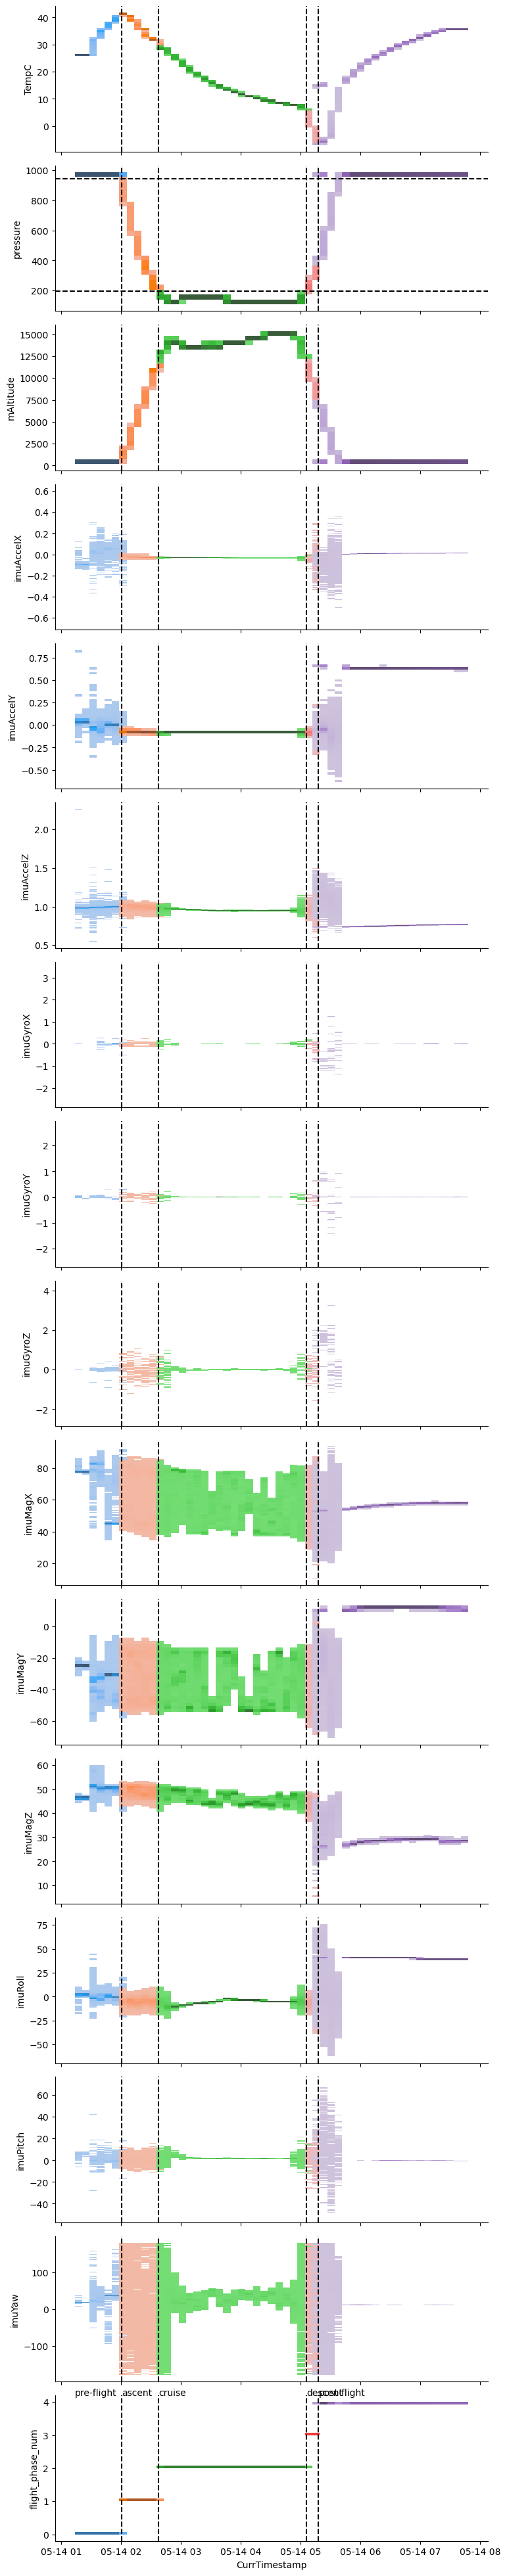

In [20]:
# View versus time
g = sns.PairGrid(imu_log_df, x_vars=['CurrTimestamp'], aspect=3, hue='flight_phase')
g.map_offdiag(sns.histplot)

for ax_row in g.axes:
    ax = ax_row[0]
    
    if ax.get_ylabel() == 'pressure':
        ax.axhline(
            p_landed,
            color = 'k',
            linestyle = '--',
        )
        ax.axhline(
            p_cruising,
            color = 'k',
            linestyle = '--',
        )
    
    for ind in transition_indices:
        ax.axvline(
            imu_log_df.loc[ind,'CurrTimestamp'],
            color = 'k',
            linestyle = '--',
        )
        
min_times = imu_log_df.groupby('flight_phase')['CurrTimestamp'].min()
for phase in min_times.index:
    ax.annotate(
        text = phase,
        xy = (min_times.loc[phase], 1),
        xycoords = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes),
        # xytext = (5,5),
        # textcoords = 'offset points',
    )

In [21]:
# Select cruise data
cruise_data = imu_log_df.loc[imu_log_df['flight_phase'] == 'cruise']
cruise_data = cruise_data.set_index('CurrTimestamp')

In [22]:
# Get rolling deviation
cruise_rolling = cruise_data.rolling(window=pd.Timedelta(rolling_window_in_min, 'min'))
cruise_rolling_std = cruise_rolling.std(numeric_only=True)

In [23]:
# Identify and store steady data
cruise_data.loc[:,'is_steady'] = cruise_rolling_std[column_for_steady] < mult_of_std_for_steady * np.nanmedian(cruise_rolling_std[column_for_steady])
cruise_rolling_std.loc[:,'is_steady'] = cruise_data['is_steady']
imu_log_df['is_steady'] = False
imu_log_df.loc[imu_log_df['flight_phase'] == 'cruise','is_steady'] = cruise_data['is_steady'].values

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

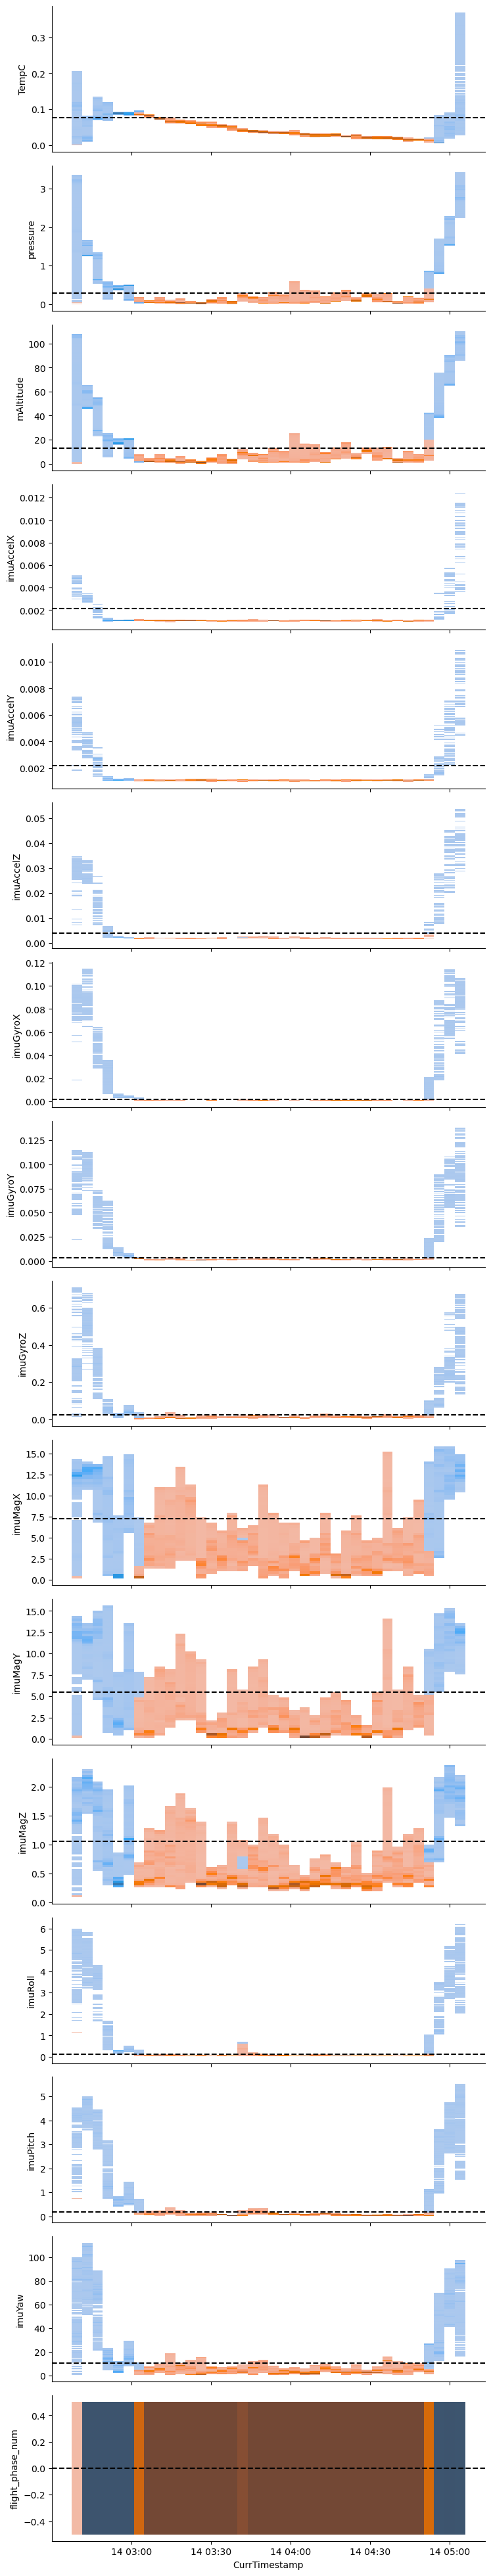

In [24]:
# View versus time
g = sns.PairGrid(cruise_rolling_std.reset_index(), x_vars=['CurrTimestamp'], hue='is_steady', aspect=3)
g.map_offdiag(sns.histplot)

for ax_row in g.axes:
    ax = ax_row[0]
    y_key = ax.get_ylabel()
    med_std = np.nanmedian(cruise_rolling_std[y_key])
    ax.axhline(
        mult_of_std_for_steady * med_std,
        color = 'k',
        linestyle = '--',
    )

### Steady flight visual inspection

This is the cleanest data we could hope for, so let's take a look at it.

In [25]:
steady_data = imu_log_df.loc[imu_log_df['is_steady']]

In [26]:
instruments = {
    'Accel': [ 'imuAccelX', 'imuAccelY', 'imuAccelZ', ],
    'Gyro': [ 'imuGyroX', 'imuGyroY', 'imuGyroZ', ],
    'Mag': [ 'imuMagX', 'imuMagY', 'imuMagZ', ],
    'RollPitchYaw': [ 'imuRoll', 'imuPitch', 'imuYaw', ],
}

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

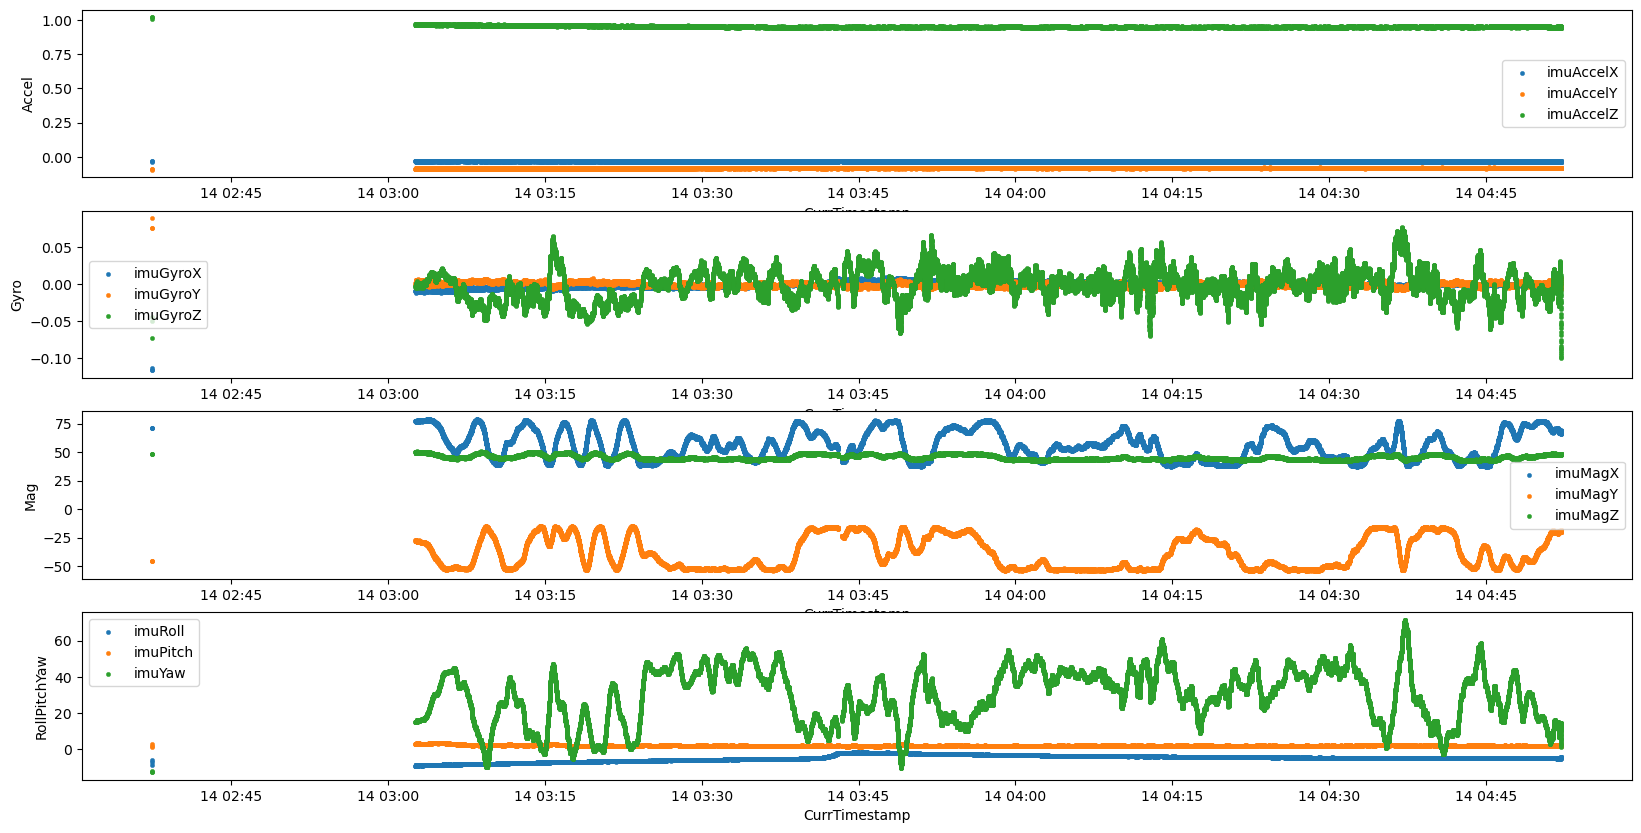

In [27]:
mosaic = [ [ _, ] for _ in instruments.keys() ]

fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(mosaic)

for inst_name, inst_keys in instruments.items():
    
    ax = ax_dict[inst_name]
    
    for inst_key in inst_keys:
        sns.scatterplot(
            steady_data,
            x = 'CurrTimestamp',
            y = inst_key,
            ax = ax,
            edgecolor=None,
            s = 10,
            label = inst_key,
        )
        
    ax.legend()
    ax.set_ylabel(inst_name)

## Compare Match Between IMU and GPS Logs

In [28]:
# Look at acceleration data to identify launch point
accel_data = imu_log_df[['CurrTimestamp', 'imuAccelX', 'imuAccelY', 'imuAccelZ']]
accel_data.set_index('CurrTimestamp', inplace=True)
accel_data = accel_data.dropna()

In [29]:
# Assume the maximum rolling acceleration during the pre-flight marks the launch
accel_rolling_mean = accel_data.rolling(window=pd.Timedelta(rolling_window_in_min*0.5, 'min')).mean()
rolling_mean_mag = np.linalg.norm(accel_rolling_mean, axis=1)
end_of_preflight = imu_log_df.loc[imu_log_df['flight_phase']=='pre-flight', 'CurrTimestamp'].max()
launch_time = accel_data.index[np.argmax(rolling_mean_mag[accel_data.index<end_of_preflight])]

In [30]:
gps_log_df = mm.flight.gps_log_df

In [31]:
# Convert to datetime, toss out recordings not associated with the flight itself.
gps_log_df.drop(gps_log_df.index[gps_log_df['CurrTimestamp'] < pd.to_datetime('2022-5-13 20')], inplace=True)

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

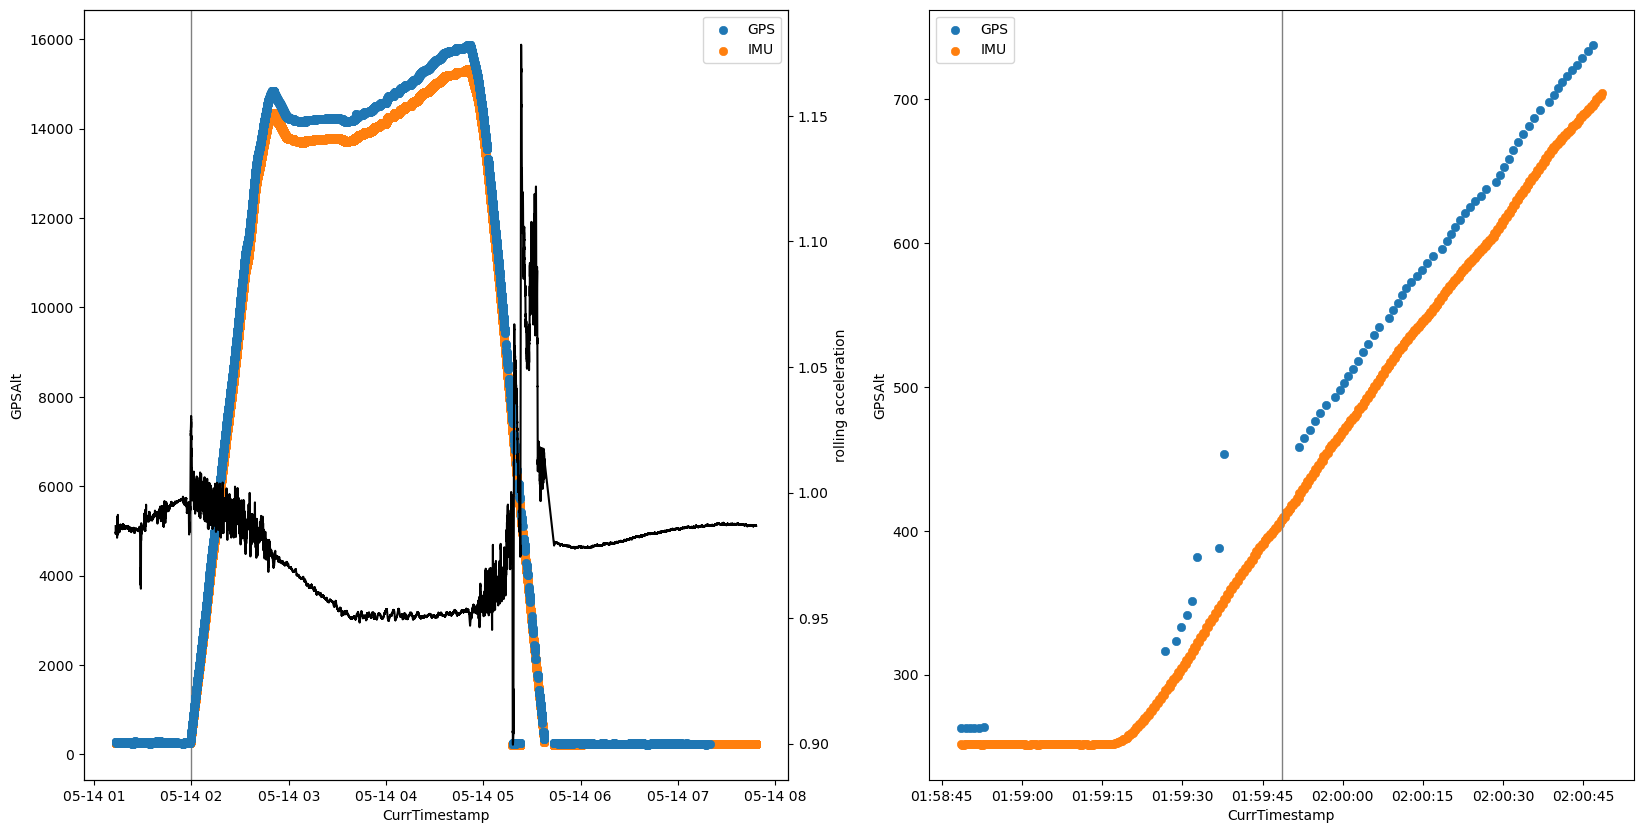

In [32]:
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic([['overall', 'zoomed', ]])

xlims = {
    'overall': None,
    'zoomed': (launch_time - pd.Timedelta(1, 'min'), launch_time + pd.Timedelta(1, 'min')),
}
for ax_key in ['overall', 'zoomed']:
    
    ax = ax_dict[ax_key]
    
    if xlims[ax_key] is not None:
        gps_selected = gps_log_df.loc[(
            (gps_log_df['CurrTimestamp'] > xlims[ax_key][0]) &
            (gps_log_df['CurrTimestamp'] < xlims[ax_key][1])
        )]
        imu_selected = imu_log_df.loc[(
            (imu_log_df['CurrTimestamp'] > xlims[ax_key][0]) &
            (imu_log_df['CurrTimestamp'] < xlims[ax_key][1])
        )]
    else:
        gps_selected = gps_log_df
        imu_selected = imu_log_df
    
    sns.scatterplot(
        gps_selected,
        x = 'CurrTimestamp',
        y = 'GPSAlt',
        edgecolor = None,
        label = 'GPS',
        ax = ax,
        zorder = 100,
    )
    sns.scatterplot(
        imu_selected,
        x = 'CurrTimestamp',
        y = 'mAltitude',
        edgecolor = None,
        label = 'IMU',
        ax = ax,
    )
    
    ax.axvline(
        launch_time,
        color = '0.5',
        linewidth = 1,
    )
    
    if ax_key == 'overall':
        ax2 = ax.twinx()
        ax2.plot(
            accel_data.index,
            rolling_mean_mag,
            color = 'k',
        )
        ax2.set_ylabel('rolling acceleration')
    ax.legend()
    
# ax.scatter(
#     gps_log_df['CurrT
# )

The match-up between the GPS and IMU data is not bad. We'll try using them as-is. The magnitude of the acceleration matches with the launch time to within a minute, but is still off by ~30 seconds.

# Image Calibration

## Inspect a Random Image

In [33]:
fp = rng.choice(mm.flight.image_fps)

In [34]:
img = mm.flight.get_rgb_img(fp)

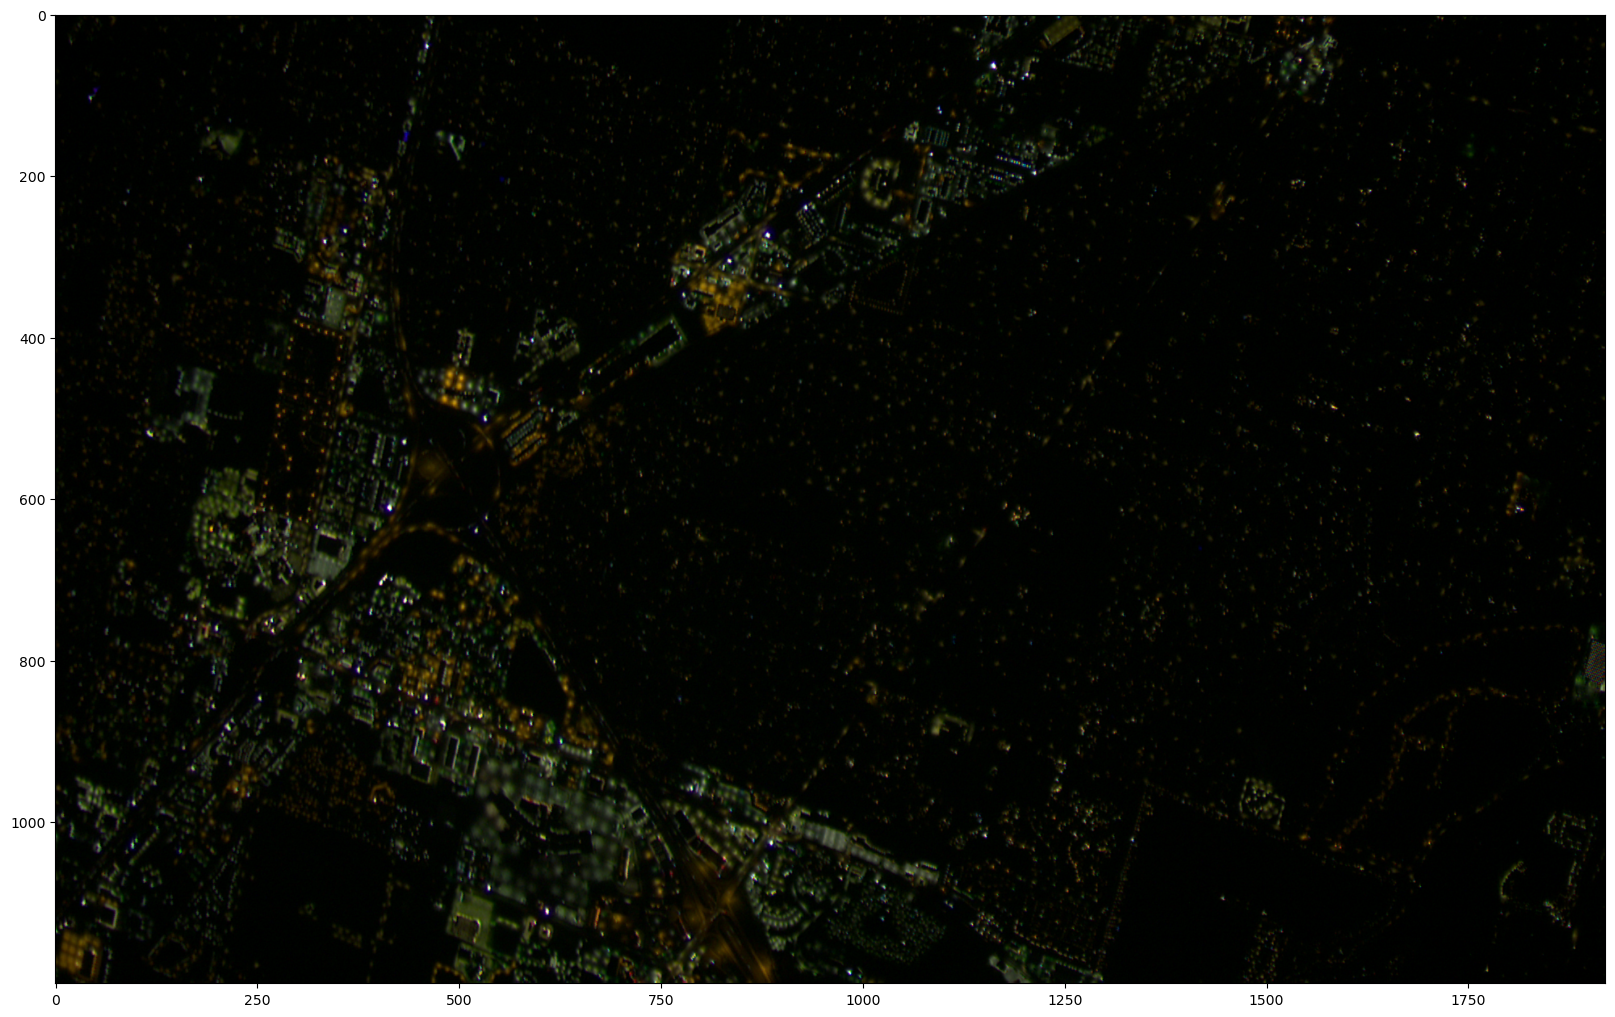

In [35]:
mm.data_viewer.plot_img(img)

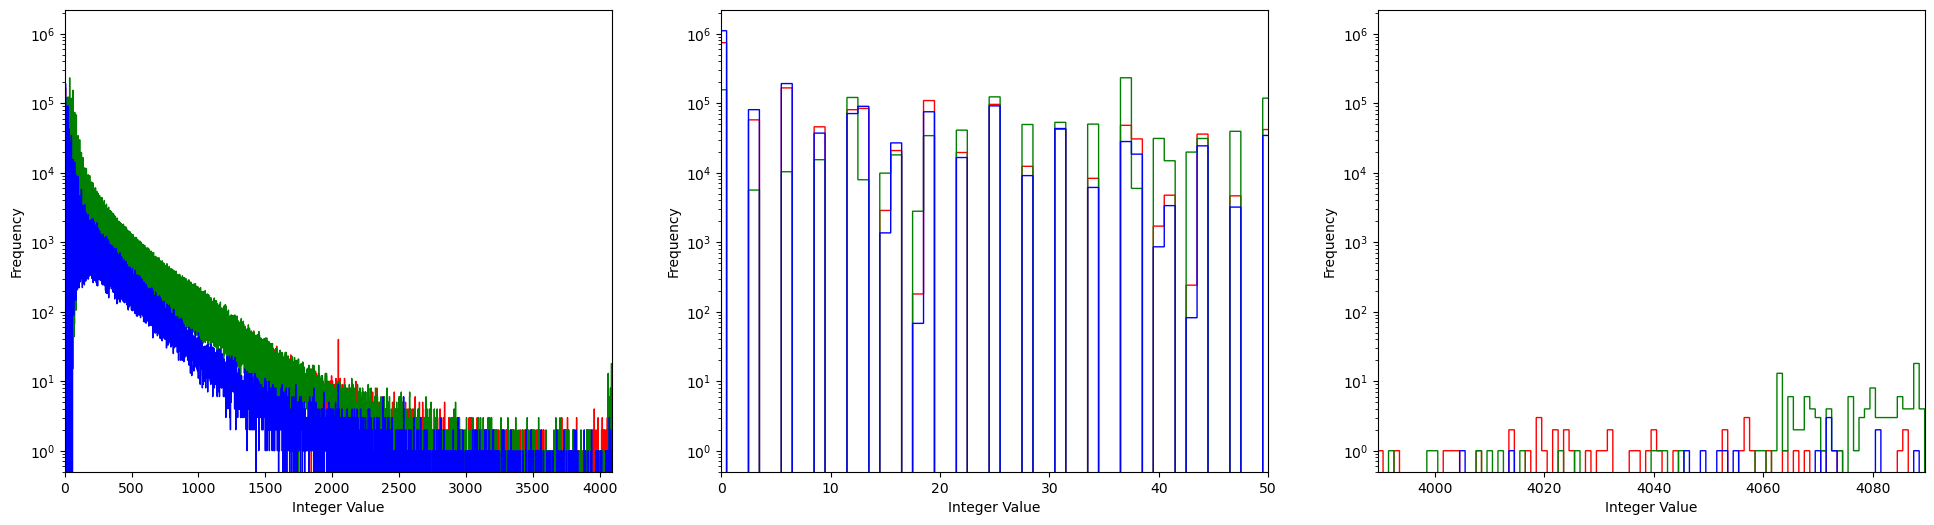

In [36]:
bins = np.arange(-0.5, mm.flight.max_val-0.5, 1)
plt_types = ['big_picture', 'zoomed', 'zoomed_upper']

# Look at brightness distribution
fig = plt.figure(figsize=(8*len(plt_types),6))

xlims = [ (bins[0], bins[-1]), (0, 50), (bins[-1]-100, bins[-1]) ]
ax_dict = fig.subplot_mosaic([plt_types,])

colors = ['red', 'green', 'blue']
for j, plt_type in enumerate(plt_types):
    
    ax = ax_dict[plt_types[j]]
    for i, color in enumerate(colors):
        
        arr = img[:,:,i] * mm.flight.max_val

        ax.hist(
            arr.flatten(),
            bins = bins,
            color = color,
            histtype = 'step',
        )
        ax.set_xlim(xlims[j])

    ax.set_yscale('log')
    
    ax.set_xlabel( 'Integer Value', )
    ax.set_ylabel( 'Frequency', )

## Inspect a Calibration Image

In [37]:
cal_image_dir = os.path.join( google_drive_dir, 'Shared drives/NITELite/Data & Analysis/Calibration Tests/3.19.22 Complete Calib Set/23085686_1sec_flatFrames' )

In [38]:
fp = rng.choice(glob.glob(os.path.join(cal_image_dir, '*.raw')))

In [39]:
img = mm.flight.get_rgb_img(fp)

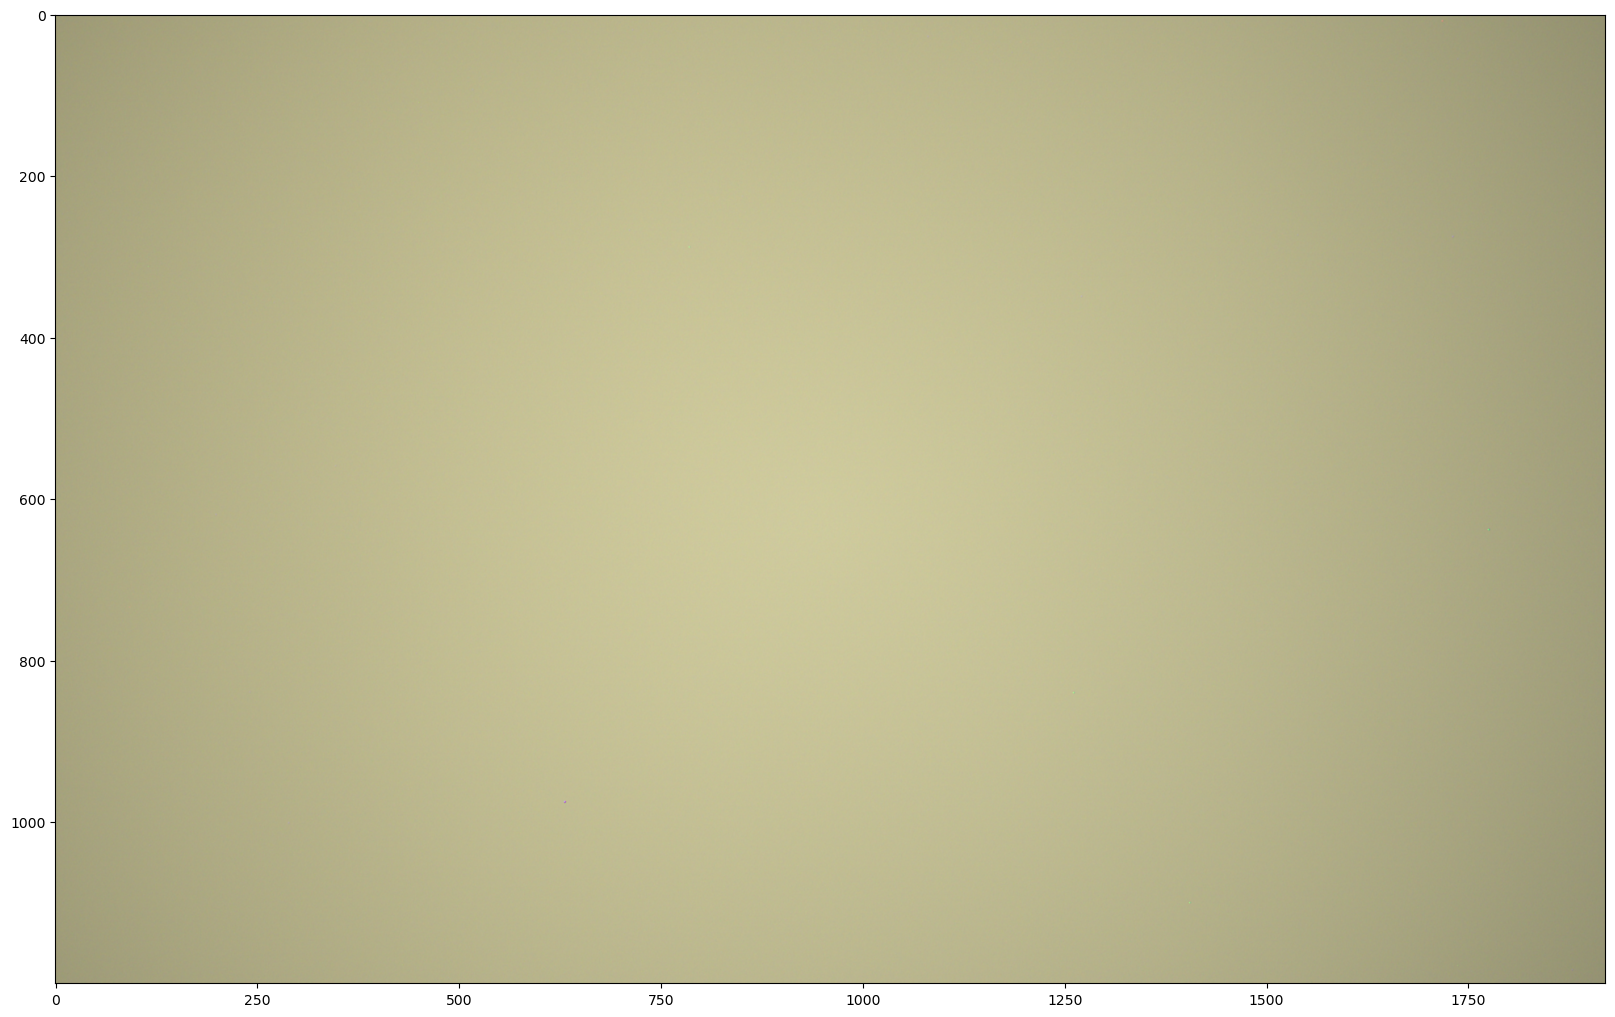

In [40]:
mm.data_viewer.plot_img(img)

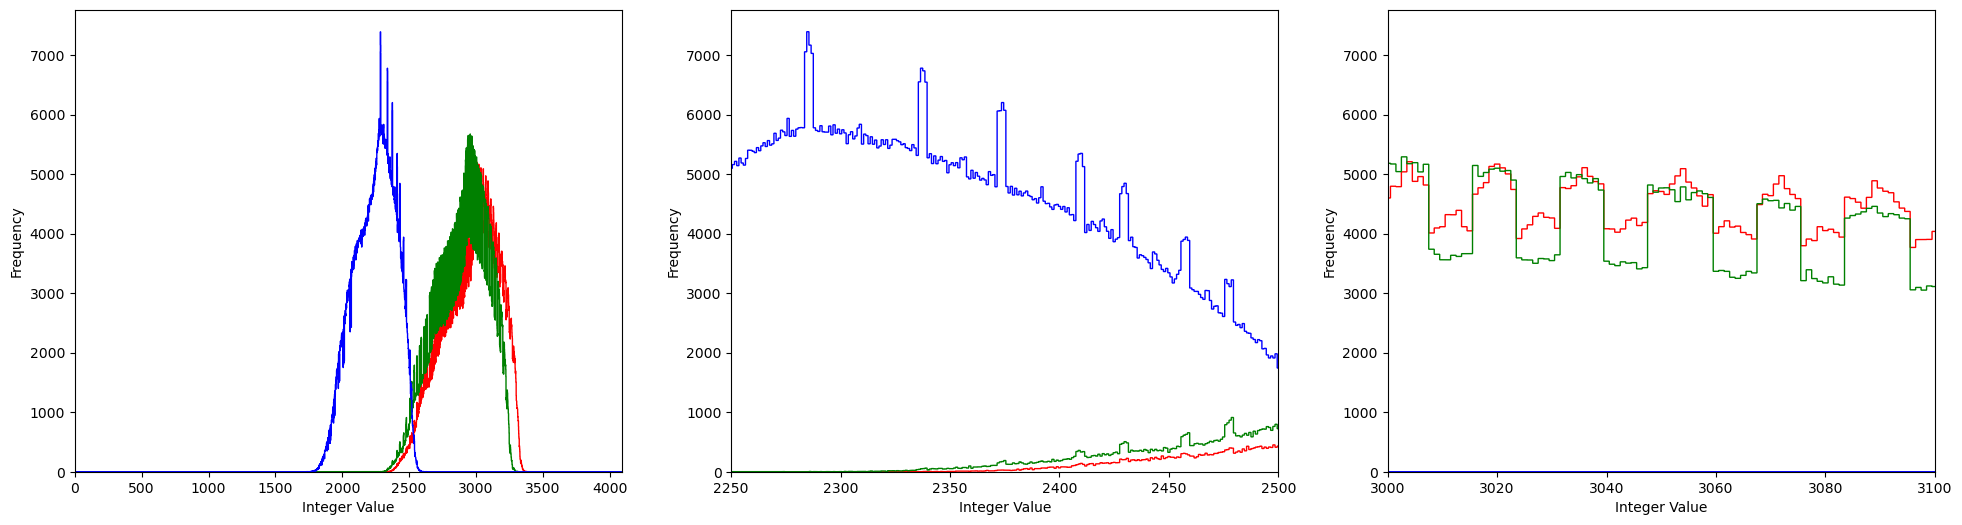

In [41]:
bins = np.arange(-0.5, mm.flight.max_val-0.5, 1)
plt_types = ['big_picture', 'zoomed', 'zoomed_upper']

# Look at brightness distribution
fig = plt.figure(figsize=(8*len(plt_types),6))

xlims = [(bins[0], bins[-1]), (2250, 2500), (3000, 3100)]
ax_dict = fig.subplot_mosaic([plt_types,])

colors = ['red', 'green', 'blue']
for j, plt_type in enumerate(plt_types):
    
    ax = ax_dict[plt_types[j]]
    for i, color in enumerate(colors):
        
        arr = img[:,:,i] * mm.flight.max_val

        ax.hist(
            arr.flatten(),
            bins = bins,
            color = color,
            histtype = 'step',
        )
        ax.set_xlim(xlims[j])

    # ax.set_yscale('log')
    
    ax.set_xlabel( 'Integer Value', )
    ax.set_ylabel( 'Frequency', )

# Georeferencing

In [42]:
metadata = mm.flight.metadata

In [43]:
# We'll keep track of what images we expect to be valid along the way
metadata['valid'] = True

## Rotate

In [44]:
# Get the rotation object
rot = scipy.spatial.transform.Rotation.from_euler(
    'XZY',
    metadata[['imuPitch', 'imuYaw', 'imuRoll']],
    degrees=True,
)

## Calculate Center and Radius in Local Coords

Given a sensor with position vector $\vec p$ pointed in direction $\hat v$ we want to find the position vector of the source image,

\begin{equation}
\vec s = \vec p + \vec v
\end{equation}

The main unknown in this equation is the magnitude of $\vec v$.
Assuming the sensor is a height $h$ above a flat surface then $h\, /\, \mid \vec v \mid = \cos \phi$, where $\phi$ is the angle between a line connecting the ground and the sensor and $\hat v$.
If $\theta$ is the standard spherical angle determining the z-component of $\hat v$ then $\phi = \pi - \theta$.
Doing some algebra we get $\mid \vec v \mid = - h\,/\, \mid\hat v_z \mid$.
Plugging in and simplifying, we get

\begin{equation}
\vec s = (p_x - h \mid\hat v_x \mid / \mid\hat v_z \mid) \hat x + (p_y - h \mid\hat v_y \mid / \mid\hat v_z \mid) \hat y
\end{equation}

In practice we'll often set $\vec p = \langle 0, 0, h \rangle$ and then deal with the conversion to a uniform reference frame during the conversion to geo-coordinates, simplifying this to 
\begin{equation}
\vec s = \langle - h \mid\hat v_x \mid / \mid\hat v_z \mid,\,\, - h \mid\hat v_y \mid / \mid\hat v_z \mid \rangle
\end{equation}

This is the general solution for any $\hat v$, but the special case we care most about is the center of the image.

In [45]:
# Height above ground
height = metadata['mAltitude'] - ground_alt

# Negative height is no good.
metadata.loc[height<0, 'valid'] = False

In [46]:
# Get image centers
vhat_sensor_center = rot.apply([0, 0, -1])
d_to_src = - height.values / vhat_sensor_center[:,2]
image_center_coords = d_to_src[:,np.newaxis] * vhat_sensor_center[:,:2]
metadata[['img_center_x', 'img_center_y']] = image_center_coords
metadata['img_center_tilt'] = np.arccos(-vhat_sensor_center[:,2]) * 180. / np.pi

In addition to the center of the vector, we'd like to estimate a radius $r$ which we expect to enclose the image.
This radius should account for both (a) geometric effects and (b) error in georeferencing.
We can parameterize this radius according to an angle $\xi = \epsilon \alpha$ where $\alpha$ is the angular radius of the image and $\epsilon$ is a multiplicative error term.
Then, neglecting warping from the image being captured at an angle (for the radius we'll assume that this is wrapped into $\epsilon$),

\begin{align}
r &= \mid\vec v \mid \tan \xi \\
&= - h\,/\, \mid\hat v_z \mid \tan( \epsilon \alpha)
\end{align}

In [47]:
# We'll estimate the angular radius of the image as the angular width of
# the sensor multiplied by the ratio of the image diagonal to image width
angular_radius = img_angular_error * (img_angular_width / 2.) * (np.linalg.norm(mm.flight.img_shape) / mm.flight.img_shape[1])
img_radius = np.abs(d_to_src * np.tan(angular_radius * np.pi / 180.))
metadata['img_radius'] = img_radius

In [48]:
# Anything where the angular radius overlaps the horizon
# (i.e. the picture is partially of the horizon)
# is also no good
max_center_angle = 90. - angular_radius
is_sideways = -vhat_sensor_center[:,2] < np.cos(max_center_angle * np.pi / 180.)
metadata.loc[is_sideways, 'valid'] = False

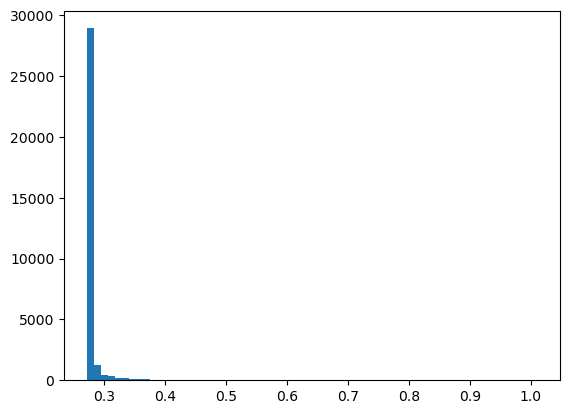

In [49]:
# We can see that the radius of the image is typically ~0.4 * the height
_ = plt.hist(img_radius[metadata['valid']] / height.loc[metadata['valid']], bins=64)

## Convert to Geo-coordinates

In [50]:
# Sensor coordinates
sensor_coords = gpd.points_from_xy(metadata['GPSLat'], metadata['GPSLong'], crs=ang_crs)
sensor_coords_cart = sensor_coords.to_crs(cart_crs)
metadata['sensor_coords'] = sensor_coords_cart

In [51]:
# Image coordinates
img_coords_cart = gpd.points_from_xy(
    sensor_coords_cart.x + metadata['img_center_x'],
    sensor_coords_cart.y + metadata['img_center_y'],
    crs = cart_crs,
)
img_coords = img_coords_cart.to_crs(ang_crs)

In [52]:
metadata['img_coords'] = img_coords_cart
metadata['img_center_lat'] = img_coords.x
metadata['img_center_lon'] = img_coords.y

## Calculate image edges in Geo-coordinates

In [53]:
def get_coords(vhat_in_sensor_frame):
    
    vhat = rot.apply(vhat_in_sensor_frame)
    
    d_to_src = - height.values / vhat[:,2]
    
    coords = gpd.points_from_xy(
        sensor_coords_cart.x + d_to_src * vhat[:,0],
        sensor_coords_cart.y + d_to_src * vhat[:,1],
        crs = cart_crs,
    )
    
    return coords

In [54]:
# Get the lower-left corner
rot_img_corner = scipy.spatial.transform.Rotation.from_euler(
    'yxz',
    [img_angular_width/2., img_angular_height/2., 0],
    degrees=True,
)
vhat_ll = rot_img_corner.apply([0., 0., -1.])

In [55]:
# Opposite corner
vhat_ul = np.array([-vhat_ll[0], vhat_ll[1], vhat_ll[2]])
vhat_lr = np.array([vhat_ll[0], -vhat_ll[1], vhat_ll[2]])
vhat_ur = np.array([-vhat_ll[0], -vhat_ll[1], vhat_ll[2]])

In [56]:
# Store the coords
metadata['img_ll_coords'] = get_coords(vhat_ll)
metadata['img_ul_coords'] = get_coords(vhat_ul)
metadata['img_lr_coords'] = get_coords(vhat_lr)
metadata['img_ur_coords'] = get_coords(vhat_ur)

In [57]:
# Get image bounds in coordinate system (avoids rotation)
edge_cols = ['img_{}_coords'.format(_) for _ in ['ll', 'ul', 'lr', 'ur']]
xs = np.array([metadata[_].values.x for _ in edge_cols]).transpose()
ys = np.array([metadata[_].values.y for _ in edge_cols]).transpose()
metadata['img_x_min'] = xs.min(axis=1)
metadata['img_x_max'] = xs.max(axis=1)
metadata['img_y_min'] = ys.min(axis=1)
metadata['img_y_max'] = ys.max(axis=1)

Text(0, 0.5, 'Estimated radius')

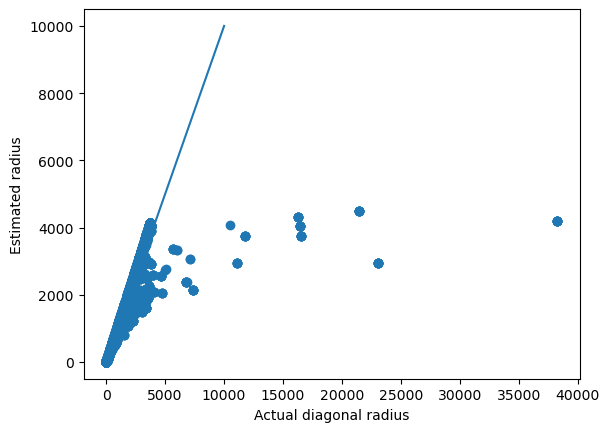

In [58]:
# Compare radius to actual image radius
actual_radius = np.sqrt(
    (metadata['img_ur_coords'].values.x - metadata['img_ll_coords'].values.x)**2.
    + (metadata['img_ur_coords'].values.y - metadata['img_ll_coords'].values.y)**2.
)/2.
fig = plt.figure()
ax = plt.gca()
ax.scatter(
    actual_radius[metadata['valid']],
    metadata['img_radius'][metadata['valid']],
)
ax.plot([0.1,1e4],[0.1,1e4])
ax.set_xlabel('Actual diagonal radius')
ax.set_ylabel('Estimated radius')
# ax.set_xscale('log')
# ax.set_yscale('log')

Apparently the estimated radius isn't conservative enough?

## Calculate all image pixels in geo-coordinates

In [59]:
horiz_angles = np.linspace(-img_angular_width/2., img_angular_width/2., mm.flight.img_shape[1])
vert_angles = np.linspace(-img_angular_height/2., img_angular_height/2., mm.flight.img_shape[0])

In [60]:
horiz_angles_mesh, vert_angles_mesh = np.meshgrid(horiz_angles, vert_angles)
pixel_rot = scipy.spatial.transform.Rotation.from_euler(
    'yxz',
    np.array([horiz_angles_mesh.flatten(), vert_angles_mesh.flatten(), np.zeros(horiz_angles_mesh.size)]).transpose(),
    degrees = True,
)
vhat_pixels_sensor_frame = pixel_rot.apply([0, 0, -1.])
# vhat_pixels = vhat_pixels.reshape((mm.flight.img_shape[0], mm.flight.img_shape[1], 3))

## When do we need to take earth's curvature into account?
A quick exploration.

In [61]:
# Calculate the radius for a given height above the earth
# (geometry calc to get difference between radius of earth and a triangle)
r_earth = 6378100.
h = np.logspace(0, 8, 32)
r = np.sqrt(h * (h + 2 * r_earth))

In [62]:
img_offset = np.linalg.norm(metadata[['img_center_x', 'img_center_y']], axis=1)

In [63]:
reference_scales = {
    'max image radius': metadata.loc[metadata['valid'],'img_radius'].max(),
    'max image offset': img_offset[metadata['valid']].max(),
    'chicago length': 40. * 1000., # 40 km
    'illinois length': 340. * 1000., # 340 km
    'US width': 4500. * 1000., # 4,500 km
}

Text(0, 0.5, 'height accuracy [m]')

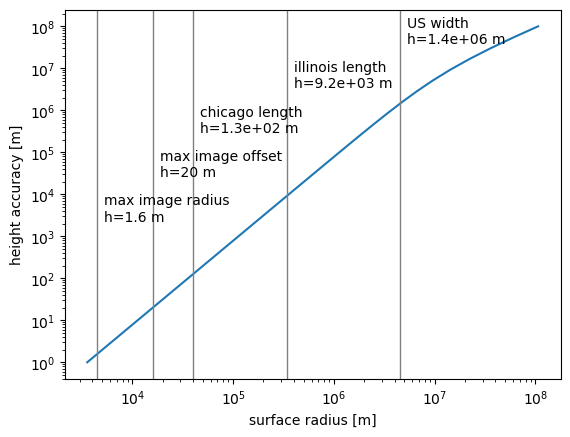

In [64]:
fig = plt.figure()
ax = plt.gca()

ax.plot(r, h)

h_interp = scipy.interpolate.interp1d(r, h)
for i, (reference_key, reference_scale) in enumerate(reference_scales.items()):
    ax.axvline(
        reference_scale,
        color = '0.5',
        linewidth = 1,
    )
    annot = ax.annotate(
        text = '{}\nh={:.2g} m'.format(reference_key, h_interp(reference_scale)),
        xy = (reference_scale, 0.4 + 0.6 * (i + 1)/len(reference_scales) ),
        xycoords = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes),
        xytext = (5,-5),
        textcoords = 'offset points',
        va = 'top',
        ha = 'left',
        zorder = 100,
    )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('surface radius [m]')
ax.set_ylabel('height accuracy [m]')

Looks like we can ignore earth curvature for the images, at least as long as we're ignoring local topography.

In [65]:
import ipyleaflet

## Mosaic

In [67]:
# Select images to mosaic
selected_metadata = metadata.loc[
    (metadata['camera_num'] == camera_num) # Correct camera
    & metadata['filename'].str.endswith('.raw') # Use raw data only for now
    & metadata['valid'] # Valid georeferencing
    & (metadata['img_radius'] > 1000.)
]

In [68]:
# Mosaic bounds
all_edgecoords = [selected_metadata['img_{}_coords'.format(_)].values for _ in ['ll', 'ul', 'lr', 'ur']]
x_min = np.min([_.x.min() for _ in all_edgecoords])
x_max = np.max([_.x.max() for _ in all_edgecoords])
y_min = np.min([_.y.min() for _ in all_edgecoords])
y_max = np.max([_.y.max() for _ in all_edgecoords])

In [69]:
# Mosaic empty grid creation
x_points = np.arange(x_min, x_max + mosaic_res, mosaic_res)
y_points = np.arange(y_min, y_max + mosaic_res, mosaic_res)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
mosaic_img = np.full(x_mesh.shape, 1.)

In [70]:
ee.Initialize()

In [71]:
# Mosaic center (in various formats)
mosaic_center_coords = gpd.points_from_xy( [0.5*(x_min + x_max)], [0.5*(y_min + y_max)], crs=cart_crs)
mosaic_center_ang_point = mosaic_center_coords.to_crs(ang_crs)[0]
mosaic_center_latlong = (mosaic_center_ang_point.x, mosaic_center_ang_point.y)
mosaic_center_longlat = (mosaic_center_ang_point.y, mosaic_center_ang_point.x)
mosaic_center_point = ee.Geometry.Point(mosaic_center_longlat)

The below attempts to display in-notebook the same Sentinel-2 data that is successfully displayed online using the default code, copied in below.

```javascript
/**
 * Function to mask clouds using the Sentinel-2 QA band
 * @param {ee.Image} image Sentinel-2 image
 * @return {ee.Image} cloud masked Sentinel-2 image
 */
function maskS2clouds(image) {
  var qa = image.select('QA60');

  // Bits 10 and 11 are clouds and cirrus, respectively.
  var cloudBitMask = 1 << 10;
  var cirrusBitMask = 1 << 11;

  // Both flags should be set to zero, indicating clear conditions.
  var mask = qa.bitwiseAnd(cloudBitMask).eq(0)
      .and(qa.bitwiseAnd(cirrusBitMask).eq(0));

  return image.updateMask(mask).divide(10000);
}

var dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate('2020-01-01', '2020-01-30')
                  // Pre-filter to get less cloudy granules.
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
                  .map(maskS2clouds);

var visualization = {
  min: 0.0,
  max: 0.3,
  bands: ['B4', 'B3', 'B2'],
};

Map.setCenter(83.277, 17.7009, 12);

Map.addLayer(dataset.mean(), visualization, 'RGB');
```

In [72]:
import geemap

In [73]:
# Sentinel-2 data. Checked on Earth engine and this provides nice urban images of Indianapolis
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
# Semi-arbitrary date range
s2 = s2.filterDate('2020-01-01', '2020-01-30') 
 # Let's not try to process things that are too cloudy
s2 = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

In [74]:
def get_filtered_img(img):
    '''Get the image, masking cloudy data pre-aggregation.
    '''
    
    # Select cloud mask layer
    qa = img.select('QA60')

    # Setup bitmask
    cloud_bitmask = 1 << 10
    cirrus_bitmask = 1 << 11

    # Get mask
    is_not_cloudy = qa.bitwise_and(cloud_bitmask).eq(0)
    is_not_cirrusy = qa.bitwise_and(cirrus_bitmask).eq(0)
    is_valid = is_not_cloudy and is_not_cirrusy

    img = img.updateMask(is_valid)

    # Scale image by scale given in dataset description
    return img.divide(10000.) 
s2_filtered = s2.map(get_filtered_img)

In [75]:
m = geemap.Map(center=mosaic_center_latlong, zoom=10)

In [77]:
# m = folium.Map(location=mosaic_center_latlong, zoom_start=10)

In [77]:
img = s2_filtered.mean()

In [78]:
m.addLayer(
    img,
    {
        'region': mosaic_center_point.buffer(10000.),
        'min': 0.0,
        'max': 0.3,
        'bands': ['B4', 'B3', 'B2'],
    },
)

In [79]:
m

Map(bottom=199242.0, center=[39.75893570672903, -86.29005432128906], controls=(WidgetControl(options=['positio…

In [66]:
mosaic_res = 1000. # In meters

In [70]:
# DEBUG
i_displayed = len(selected_metadata)//2

In [71]:
# Loop over 
for i in tqdm.tqdm(range(len(selected_metadata))):
    
    # DEBUG
    if i != i_displayed:
        continue
    
    row = selected_metadata.iloc[i]

    # Load the image
    image_fn = os.path.basename(row['filename'])
    image_fp = os.path.join(image_dir, image_fn)
    img_vals = mm.flight.get_rgb_img(image_fp)

    # Choose only green band for the moment
    img_vals = img_vals[:,:,1]
    
    # Get the pixel directions
    rot_i = scipy.spatial.transform.Rotation.from_euler(
        'XZY',
        row[['imuPitch', 'imuYaw', 'imuRoll']],
        degrees=True,
    )
    vhat_pixels_i = rot_i.apply(vhat_pixels_sensor_frame)
    
    # Get the pixel coordinates
    height = row['mAltitude'] - ground_alt
    d_to_src = -height / vhat_pixels_i[:,2]
    pixel_coords = gpd.points_from_xy(
        row['sensor_coords'].x + d_to_src * vhat_pixels_i[:,0],
        row['sensor_coords'].y + d_to_src * vhat_pixels_i[:,1],
        crs = cart_crs,
    )
    
    # # There might be room to get the coords this way
    # # Or it could be overly simplistic
    # img_xs = np.linspace(row['image_ll'].x, row['image_uu'].x, mm.flight.img_shape[1])
    # img_ys = np.linspace(row['image_ll'].y, row['image_uu'].y, mm.flight.img_shape[0])

    # Interpolate
    interped = scipy.interpolate.griddata(
        np.array([pixel_coords.x, pixel_coords.y]).transpose(),
        img_vals.flatten(),
        np.array([x_mesh.flatten(), y_mesh.flatten()]).transpose(),
    )
    values = interped.reshape(x_mesh.shape)

    # Update the mosaic
    is_valid = np.invert(np.isnan(values))
    mosaic_img[is_valid] = values[is_valid]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6861/6861 [00:28<00:00, 240.46it/s]


## Inspect Individual Images

In [107]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [106]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [95]:
gdf = gpd.GeoDataFrame(
    geometry=selected_metadata['img_coords'],
)

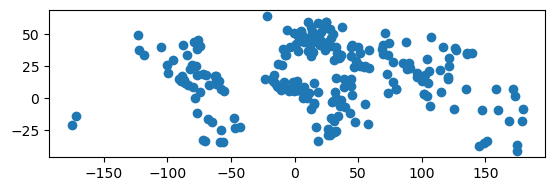

In [109]:
fig = plt.figure()
ax = plt.gca()

world.plot(ax=ax)
# gdf.plot(ax=ax)

# ax.set_xlim(gdf['geometry'].x.min(), gdf['geometry'].x.max())
# ax.set_ylim(gdf['geometry'].y.min(), gdf['geometry'].y.max())

ax.set_aspect('equal')

In [92]:
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

In [72]:
img_ll_coords = selected_metadata['img_ll_coords'].values.to_crs(ang_crs)
img_ul_coords = selected_metadata['img_ul_coords'].values.to_crs(ang_crs)
img_lr_coords = selected_metadata['img_lr_coords'].values.to_crs(ang_crs)
img_ur_coords = selected_metadata['img_ur_coords'].values.to_crs(ang_crs)

In [229]:
metadata[['GPSLat','GPSLong']].median()

GPSLat     39.725937
GPSLong   -86.188924
dtype: float64

In [232]:
m = folium.Map(location=metadata[['GPSLat','GPSLong']].median(), zoom_start=10)

In [234]:
# Flight path
folium.PolyLine(
    metadata[['GPSLat','GPSLong']],
    tooltip='Flight Path',
    color = '#000000',
).add_to(m)

In [102]:
# Image center, lower-left, and upper-right paths
# Center
folium.PolyLine(
    selected_metadata[['img_center_lat', 'img_center_lon']],
    tooltip='Image Centers',
    color = palette.as_hex()[0],
).add_to(m)
# Lower-left
folium.PolyLine(
    np.array([img_ll_coords.x, img_ll_coords.y]).transpose(),
    tooltip='Image Lower Left',
    color = palette.as_hex()[1],
).add_to(m)
# Uper-right
img_ur_latlong = selected_metadata['img_ur_coords'].values.to_crs(ang_crs)
folium.PolyLine(
    np.array([img_ur_coords.x, img_ur_coords.y]).transpose(),
    tooltip='Image Upper Right',
    color = palette.as_hex()[2],
).add_to(m)

In [103]:
# Marker for the test image
# Center
folium.Marker(
    row[['img_center_lat', 'img_center_lon']],
    popup='Test Image; i={}'.format(i_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[0]),
).add_to(m)
# Lower left
folium.Marker(
    (img_ll_coords[i_displayed].x, img_ll_coords[i_displayed].y),
    popup='Lower Left; i={}'.format(i_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[1]),
).add_to(m)
# Upper left
folium.Marker(
    (img_ul_coords[i_displayed].x, img_ul_coords[i_displayed].y),
    popup='Upper Left; i={}'.format(i_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[3]),
).add_to(m)
# Lower right
folium.Marker(
    (img_lr_coords[i_displayed].x, img_lr_coords[i_displayed].y),
    popup='Lower Right; i={}'.format(i_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[4]),
).add_to(m)
# Upper Right
folium.Marker(
    (img_ur_coords[i_displayed].x, img_ur_coords[i_displayed].y),
    popup='Upper Right; i={}'.format(i_displayed),
    icon=folium.Icon(color='gray',icon_color=palette.as_hex()[2]),
).add_to(m)

In [104]:
# Square box that should enclose a given image

# Square in cartesian space
x_length = row['img_x_max'] - row['img_x_min']
y_length = row['img_y_max'] - row['img_y_min']
inclusive_halflength = np.max([x_length, y_length]) / 2.
square_coords = np.array([
    [row['img_coords'].x - inclusive_halflength, row['img_coords'].y - inclusive_halflength],
    [row['img_coords'].x + inclusive_halflength, row['img_coords'].y - inclusive_halflength],
    [row['img_coords'].x + inclusive_halflength, row['img_coords'].y + inclusive_halflength],
    [row['img_coords'].x - inclusive_halflength, row['img_coords'].y + inclusive_halflength],
    [row['img_coords'].x - inclusive_halflength, row['img_coords'].y - inclusive_halflength],
])
# Convert to latlong
square_coords_latlong =  gpd.points_from_xy(
    square_coords[:,0],
    square_coords[:,1],
    crs = cart_crs,
).to_crs(ang_crs)
folium.vector_layers.Polygon(
    np.array([square_coords_latlong.x, square_coords_latlong.y]).transpose(),
).add_to(m)

In [105]:
# Mosaic
bounds_coords = gpd.points_from_xy(
    [x_min, x_max],
    [y_min, y_max],
    crs=cart_crs
).to_crs(ang_crs)
bounds = [[bounds_coords.x[0], bounds_coords.y[0]], [bounds_coords.x[1], bounds_coords.y[1]]]
folium.raster_layers.ImageOverlay(
    np.rot90(mosaic_img),
    bounds=bounds,
).add_to(m)


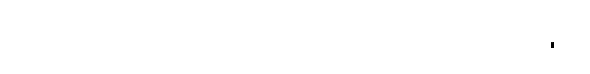

In [106]:
m

# External Data

In [176]:
scale=1000

In [201]:
url = landsat_img.getThumbUrl({
    'min': 0, 'max': 30000.0, 'region': med_poi.buffer(100),
})
print(url)

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/76590d44735a0cbdd515e4d4f43533b2-e66e096ffd6a76313794917249102200:getPixels


In [170]:
print(landsat.first().sample(med_poi, scale).get('B4').getInfo())

None


In [171]:
metadata[['GPSLat','GPSLong']].median()

GPSLat     39.725937
GPSLong   -86.188924
dtype: float64

In [136]:
med_poi = ee.Geometry.Point(*metadata[['GPSLat','GPSLong']].median())

In [110]:
import ee
# ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [111]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [112]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [113]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [114]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 196 m
Average daytime LST at urban point: 23.12 °C
Land cover value at urban point is: 13


In [115]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

In [116]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [117]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

0            time   datetime  LST_Day_1km
3   1483488000000 2017-01-04         3.01
4   1483574400000 2017-01-05         2.39
5   1483660800000 2017-01-06         0.89
6   1483747200000 2017-01-07        -0.11
15  1484524800000 2017-01-16         2.33

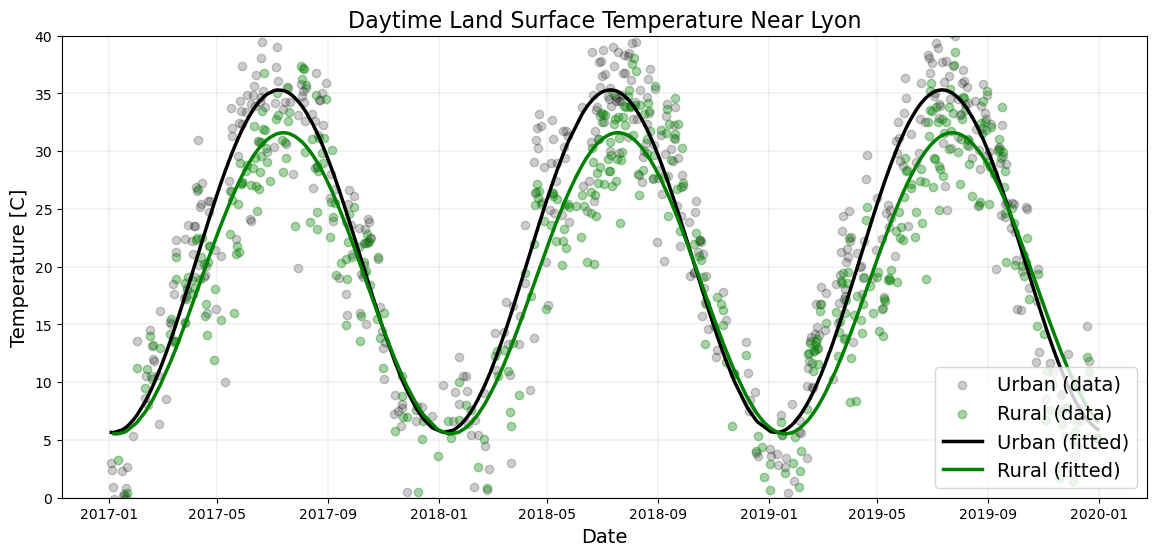

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [119]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)

In [120]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [121]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/3bc4413e4552eae1fc382b446c52ce06-f8dafc879bde775f9bcd2b7e5487ecea:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [122]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [123]:
# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': lyon, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

In [124]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# Clip the image by France.
elv_fr = elv_img.clip(france)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in France.
Image(url=url)

In [125]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_lyon_france',
                                     scale=30,
                                     region=lyon,
                                     fileNamePrefix='my_export_lyon',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [126]:
task.status()

{'state': 'READY',
 'description': 'elevation_near_lyon_france',
 'creation_timestamp_ms': 1695411865549,
 'update_timestamp_ms': 1695411865549,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'FJQRIW77NSYE7BT2NV7YER5C',
 'name': 'projects/earthengine-legacy/operations/FJQRIW77NSYE7BT2NV7YER5C'}

In [127]:
import folium

# Define the center of our map.
lat, lon = 45.77, 4.855

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map

In [128]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [129]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [130]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

In [131]:
my_map.save('my_lc_interactive_map.html')